In [75]:
import json
import datetime
import altair as alt
import pandas as pd
import numpy as np
import os

hits = [
'2018-08-10_00-00-00', #0
'2018-08-29_11_32_44',
'2018-08-29_22-54-16', #2
'2018-09-05_21-38-43',
'2018-09-07_11-34-48',
'2018-09-08_09-41-18',
'2018-09-09_10-28-14', #6
'2018-09-10_10-36-44', #7
'2018-09-11_11-09-18',
]
base = 'hits/' + hits[8]
def cd(file):
    return os.path.join(base, file)

In [76]:
def duration_plot(assignments):
    times = []
    submit_times = []
    for l in assignments:
        submit = datetime.datetime.strptime(l['SubmitTime'][:-6], "%Y-%m-%d %H:%M:%S")
        accept = datetime.datetime.strptime(l['AcceptTime'][:-6], "%Y-%m-%d %H:%M:%S")
        submit_times.append(submit)
        diff = (submit - accept).total_seconds()/60.0
        times.append({"diff": diff})
    spec = {
      "data": {"values": times},
      "mark": "bar",
      "encoding": {
        "x": {
          "field": "diff",
          "type": "quantitative",
          "bin": {"step": 1} 
        },
        "y": {
          "aggregate": "count",
          "type": "quantitative"
        }
      }
    }
    print('min - max: ', min(submit_times), max(submit_times))
    print('mean duration: ', np.mean(list(map(lambda d: d['diff'], times))))
    return alt.VegaLite(spec)

min - max:  2018-09-11 11:11:27 2018-09-11 13:39:09
mean duration:  10.3905555556


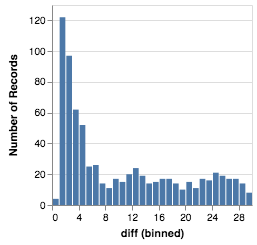

min - max:  2018-09-11 14:54:49 2018-09-11 17:05:55
mean duration:  12.5688


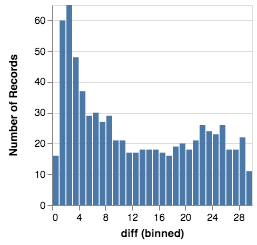

In [77]:
listener_assignments = json.load(open(cd('listener.assignments')))
speaker_assignments = json.load(open(cd('speaker.assignments')))
display(duration_plot(speaker_assignments))
display(duration_plot(listener_assignments))

In [78]:
import collections 

def by_worker(assign):
    workers = collections.defaultdict(int)
    for a in assign:
        workers[a['WorkerId']] += 1
    descending = sorted(workers.items(), key=lambda a: -a[1])
    return collections.OrderedDict(descending) 

listener_counts = by_worker(listener_assignments)
speaker_counts = by_worker(speaker_assignments)
intersection = set(speaker_counts.keys()).intersection(listener_counts.keys())

for k in intersection:
    print(k, listener_counts[k], speaker_counts[k])
print('speak: {} listener {} overlap {}'.format(len(speaker_counts), len(listener_counts), len(intersection)))

A33UQADFRXM0N 37 2
AUI3R928P63B0 26 37
A1TVJ4HKOOIL6L 7 15
AISNLDPD2DFEG 4 17
AG5PMV0NS3A44 10 21
A98E8M4QLI9RS 28 21
A03922113RU44GENR8ATX 13 6
A35JQ3VLA4WBZC 14 21
A1P0XSCJ9XAV74 16 6
ASL76QYDI0QLK 15 16
A374STD2W8N1U8 23 1
A3W24IE6P9O302 43 65
AVBRJBJONL47I 9 2
A36CQIFWEDEECU 11 20
AUPHYAKC58LPA 6 10
A15WCNO32MHBAF 3 11
A3F9N2P4NUUR7S 26 35
A2L5J9XWM1ODIL 8 43
A2R3KI7FWWGBIV 26 50
A1IN92CQSAJE9Z 8 1
APJJ1HHD2GGFS 3 2
A2KAZBONNVNV5O 17 2
A2S96ZZ70YFPSK 17 7
ARB52L0KXB1DE 4 12
A3CGA66ES1ZTKC 6 6
A1TGV7LT6LTIQU 17 14
speak: 68 listener 104 overlap 26


In [143]:
import pandas as pd
import collections
import mturk
from mturk.query_line import QueryLine
pd.set_option('display.max_colwidth', 200)
pd.set_option("display.max_rows", None)

def isfloat(string):
    try:
        float(string)
        return True
    except ValueError:
        return False
    
def reduce_formula(x):
    if x.find(':') == -1:
        print('COLON_NOT_FOUND', x)
        return 'COLON_NOT_FOUND'
    v = x[x.index(':')+1:]
    return x[:x.index(':')] + ('number' if isfloat(v) else v)



def to_html(spec):
    options = {'rendered': 'svg', 'width': 800, 'height': 800}
    return alt.utils.html.spec_to_html(spec, 'vega-lite', '3', '3', '2', embed_options=options)


processing 2018-08-10_00-00-00
processing 2018-08-29_22-54-16
processing 2018-09-05_21-38-43
processing 2018-09-07_11-34-48
processing 2018-09-08_09-41-18
processing 2018-09-09_10-28-14
processing 2018-09-10_10-36-44
processing 2018-09-11_11-09-18
COLON_NOT_FOUND set config line point y2Offset to 18
COLON_NOT_FOUND set encoding y2 type to quantitative
COLON_NOT_FOUND set encoding x2 type to nominal
COLON_NOT_FOUND set encoding y2 type to nominal
COLON_NOT_FOUND set mark point y2Offset to 40
COLON_NOT_FOUND set encoding x2 value to 34
COLON_NOT_FOUND set config area point y2Offset to 0.0
COLON_NOT_FOUND set config line point x2Offset to 75
COLON_NOT_FOUND set encoding y2 type to temporal
COLON_NOT_FOUND set encoding x2 title to XXYYZZ
COLON_NOT_FOUND set encoding x2 bin nice to false
COLON_NOT_FOUND set encoding y2 type to quantitative
COLON_NOT_FOUND set config line point x2Offset to 84
COLON_NOT_FOUND set config area point y2Offset to 43
COLON_NOT_FOUND set config line point y2Offset 

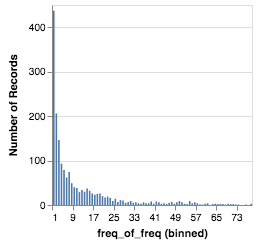

19519 10801 1794 437
number of listener pick_or_skip 46561
got 19519 examples, 143404 listeners log


In [153]:
from mturk import process_listener as pl
# adds annotations

def aggregate_all():
    examples = []
    listener_log = []
    for h in hits[0:1] + hits[2:]:
        print('processing', h)
        speaker_path = os.path.join('hits', h, 'speaker.jsonl')
        listener_path = os.path.join('hits', h, 'listener.raw.jsonl')
        lines = [QueryLine(line.strip()) for line in open(speaker_path, 'r').readlines()]
        examples += [l for l in lines if l.is_example()]
        listener_log += [QueryLine(line.strip()) for line in open(listener_path, 'r').readlines()]
    formulas = [l.example()['targetFormula'] for l in examples]
    paths = list(map(lambda x: reduce_formula(x), formulas))
    pathsset = set(paths)
    pathcounter = collections.Counter(paths)
    countisone = [k for k in pathcounter.keys() if pathcounter[k] == 1]
    freqfreq = pathcounter.values()
    spec = {
      "data": {"values": [{"freq_of_freq": v} for v in freqfreq]},
      "mark": "bar",
      "encoding": {
        "x": {
          "field": "freq_of_freq",
          "type": "quantitative",
          "bin": {"step": 1} 
        },
        "y": {
          "aggregate": "count",
          "type": "quantitative"
        }
      }
    }
    chart = alt.VegaLite(spec)
    display(chart)
    print(len(paths), len(set(formulas)), len(pathsset), len(countisone))
    
    pl.process_listener(examples, listener_log)
    speakers, listeners = pl.aggregate_turker(examples)
    print('got {} examples, {} listeners log'.format(len(examples), len(listener_log)))
    return speakers, listeners

speakers, listeners = aggregate_all()

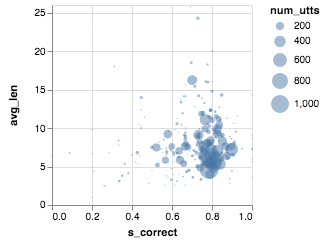

,avg_len,l_correct,l_skip,l_total,l_wrong,num_utts,s_correct,s_skip,s_total,s_wrong,total
avg_len,1.000000,0.141492,0.153054,-0.073874,-0.194994,-0.122422,0.047674,-0.048201,-0.111397,-0.032351,-0.121568
l_correct,0.141492,1.000000,-0.294534,0.235849,-0.859542,0.191554,0.362076,-0.336846,0.193431,-0.299532,0.217905
l_skip,0.153054,-0.294534,1.000000,-0.038176,-0.235231,0.082843,0.235805,-0.166660,0.086282,-0.223872,-0.031209
l_total,-0.073874,0.235849,-0.038176,1.000000,-0.219455,0.643160,0.222833,-0.186302,0.627620,-0.195816,0.891555
l_wrong,-0.194994,-0.859542,-0.235231,-0.219455,1.000000,-0.216011,-0.438863,0.387948,-0.219141,0.374165,-0.204931
num_utts,-0.122422,0.191554,0.082843,0.643160,-0.216011,1.000000,0.206027,-0.137080,0.936218,-0.187977,0.903828
s_correct,0.047674,0.362076,0.235805,0.222833,-0.438863,0.206027,1.000000,-0.712746,0.192901,-0.880335,0.224688
s_skip,-0.048201,-0.336846,-0.166660,-0.186302,0.387948,-0.137080,-0.712746,1.000000,-0.148579,0.294735,-0.168894
s_total,-0.111397,0.193431,0.086282,0.627620,-0.219141,0.936218,0.192901,-0.148579,1.000000,-0.162319,0.941367
s_wrong,-0.032351,-0.299532,-0.223872,-0.195816,0.374165,-0.187977,-0.880335,0.294735,-0.162319,1.000000,-0.191884


In [152]:
def q2row(l: QueryLine):
    return {'utterance': l.utterance(), 'workerId': l.worker_id(), 'targetFormula': l.example()['targetFormula']} 

def speaker2row(id, l: dict):
    return {'WorkerId': id, 'stats': l['stats'],
            'utts': ', '.join(l['utterances']), 'listeners': len(l['listeners'])}

def joint2row(id, l: dict):
    l['WorkerId'] = id
    return l

joint = collections.defaultdict(lambda: {'WorkerId':'', 'total': 0})

def fill_joint(rows, prefix):
    for wid, r in rows.items():
#         print('row', r)
        jr = joint[wid]
        jr['WorkerId'] = wid
        stats = r['stats']
        total = stats['correct'] + stats['wrong'] + stats['skip'] 
        correct, wrong, skip = 0.2, 0.6, 0.2
        if total != 0:
            correct = (stats['correct']) /  (total)
            wrong = (stats['wrong']) /  (total)
            skip = (stats['skip']) /  (total)
        jr[prefix + '_correct'] = correct 
        jr[prefix + '_wrong'] = wrong
        jr[prefix + '_skip'] = skip
        jr[prefix + '_total'] = total
        jr['total'] += total
        
def fill_utts(speakers):
    for wid, r in speakers.items():
#         print('row', r)
        jr = joint[wid]
        jr['WorkerId'] = wid
        utts = r['utterances']
        lenutt = len(utts)
        jr['num_utts'] = lenutt 
        jr['utts'] = utts if lenutt <= 10 else utts[0:5]
        jr['avg_len'] = np.mean([len(l.split(' ')) for l in utts])
        
fill_joint(speakers, 's')
fill_utts(speakers)
fill_joint(listeners, 'l')


records = [joint2row(k, v) for k,v in joint.items()]
agg_table = pd.DataFrame.from_records(records) 
agg_table.sort_values(by=['s_correct', 's_total', 'l_correct'], inplace=True, ascending=False)
# display(agg_table)
spec_list = []
spec_list += [{
  "data": {"values": records},
  "description": "accuracies",
  "mark": "circle",
  "encoding": {
    "x": {
      "field": "s_correct",
      "type": "quantitative"        
    },
    "y": {
      "field": "avg_len",
      "type": "quantitative"        
    },
    "size": {
        "field": "num_utts",
        "type": "quantitative"
    },
    "opacity": {"value": 0.5},
    "tooltip": {
        "field": "utts",
        "type": "nominal"
    }
  }
}]
spec_list += [{
  "data": {"values": records},
  "description": "correlation",
  "mark": "circle",
  "encoding": {
    "x": {
      "field": "s_correct",
      "type": "quantitative"        
    },
    "y": {
      "field": "l_total",
      "type": "quantitative"        
    },
    "size": {
        "field": "num_utts",
        "type": "quantitative"
    },
    "opacity": {"value": 0.5},
    "tooltip": {
        "field": "utts",
        "type": "nominal"
    }
  }
}]

chart = alt.VegaLite(spec_list[0])
display(chart)

for spec in spec_list:
    html = to_html(spec)
    name = spec['description']
    open(name + '.html', 'w').write(to_html(spec))

corr = agg_table.corr()
display(corr)
# display(agg_table)

In [86]:
ex_table = pd.DataFrame.from_records([speaker2row(k, v) for k,v in speakers.items()])
ex_table.sort_values(by=['listeners'])
display(ex_table)
open('visualize.html', 'w').write(table.to_html())

,WorkerId,listeners,stats,utts
0,A1G70F4VJOW46H,12,"{'correct': 9, 'wrong': 3, 'skip': 0}","make the dashes blue on the vertical axis, increase the markers size on the horizontal axis, make all of the markers on all axis larger, Move b to above 60, make the background lines green"
1,A1SR1UTUO8Y9RC,132,"{'correct': 94, 'wrong': 22, 'skip': 16}","Zero missing in axis, Small tabs on X axis points missing, Small tabs on both x axis and y axis are blue, X axis values got tilted, Y axis value fond is lighter in color, Graph moved to the right ..."
2,A2L5J9XWM1ODIL,326,"{'correct': 270, 'wrong': 41, 'skip': 15}","Remove everything but plot, Adjust tick marks on y axis ever so slightly, Move Glabron, Make numbers light gray, Move A and 50, Move axis titles, Enlarge numbers of x axis, Add more numbers to x a..."
3,A38WZEK3MZXR3Q,80,"{'correct': 65, 'wrong': 13, 'skip': 2}","Move graph away from age, Make a lot of grid lines, Make population large, Turn x axis title, Move 1 and 10 on the x axis out, Move y axis numbers down, Make site grey, Make legend colors very lig..."
4,AUI3R928P63B0,285,"{'correct': 258, 'wrong': 19, 'skip': 8}","Abbreviate the x-axis label., Change the x axis values color to red., Remove x and y axis labels., Lighten the color of the lines inside the chart., Change the position of the x axis label., Chang..."
5,A1TVJ4HKOOIL6L,134,"{'correct': 95, 'wrong': 31, 'skip': 8}","In new chart X axis value moved to Right side, Whole new chart gone bit left side UP which need alignment, In new chart Y axis Title moved bit down side which need to be in front of 45, In new cha..."
6,A3W24IE6P9O302,500,"{'correct': 404, 'wrong': 63, 'skip': 33}","remove the colors, change bottom to xyz, move b down, add thick gray line to bottom, make small, a y axis, remove color fill, add huge x axis, remove all color, dim the first part of the line on x..."
7,A3F9N2P4NUUR7S,283,"{'correct': 236, 'wrong': 33, 'skip': 14}","Turn graph green, change label names to ..., Make graph without y axis, Make horizontal grids red, Move up the x axis label, Make outline green, Make legend values horizontal, overlap legend valu..."
8,ACSS93E03ZUGX,313,"{'correct': 254, 'wrong': 39, 'skip': 20}","graph lines become red, dots are added, dots are added to the squiggles, Year into decade moves up slightly, graph lines become closer together, lines around circles become bolder, Weather type be..."
9,A2O97O0KHA4RWE,139,"{'correct': 105, 'wrong': 25, 'skip': 9}","make x axis label horizontal, Make y axis numbers bigger, remove x axis, x axis label, and vertical lines, add dates for all tick marks, Make dates lighter, Move horizontal lines and tick marks do..."


260939